## MOA Prediction  
### 데이터 파악  




#### train_feature
g- : gene expression data  772개의 columns > column 하나가 유전자를 의미하며 값이 높으면 발현이 높은 수준으로 된 것을 의미  
c- : cell viability data  100개의 columns > column 하나가 cell을 의미하며 값이 높으면 많이 살아있음을 의미  
3 cp_features : cp_type, cp_time, cp_dose  
cp_type - how_sample was treated : trt_cp(compound), ctl_vehicle(control pertubation > 유전자 교란)  
cp_time : 24h, 48h, 72h  
cp_dose : D1(high), D2(low)  

#### train_target  
All the targets are binary columns > whether a certain cell type responds to the drug, or not. > 1이 있으면 MOA가 있다고 할 수 있음  
Inhibitor :  A compound, or even a macromolecule, that blocks the action of an enzyme by reversible attachment  
Antagonist : A compound, often an analogue of a hormone, that binds to a receptor but elicits no response  
Agonist : A compound, often a hormone or its analogue, that binds to a receptor and elicits a response.  
Activator :  A compound that increases the rate of an enzymic reaction.  



#### non_scored_targets  
활용 어떻게 하지?
#### drug_id  
가중치 부여..?  

### 분류 방식  
Multilabel classification  
PCA로 feature들의 차원축소를 진행하고 pytorch NN모델 사용하는게 좋을 듯  
~9월 27일 - 시각화 해보고 데이터의 특성 파악  
~10월 4일 - PCA, 이상치 처리 등 데이터 전처리  
~11월 1일 - 모델링 해보기

도움되는 baseline code >> https://www.kaggle.com/namanj27/new-baseline-pytorch-moa, https://www.kaggle.com/headsortails/explorations-of-action-moa-eda

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
file1 = '/content/drive/MyDrive/Colab Notebooks/MOA/lish-moa/train_drug.csv'
file2 = '/content/drive/MyDrive/Colab Notebooks/MOA/lish-moa/train_features.csv'
file3 = '/content/drive/MyDrive/Colab Notebooks/MOA/lish-moa/train_targets_scored.csv'
file4 = '/content/drive/MyDrive/Colab Notebooks/MOA/lish-moa/train_targets_nonscored.csv'
file5 = '/content/drive/MyDrive/Colab Notebooks/MOA/lish-moa/test_features.csv'
file6 = '/content/drive/MyDrive/Colab Notebooks/MOA/lish-moa/sample_submission.csv'

In [3]:
df_train_drug = pd.read_csv(file1)
df_train = pd.read_csv(file2)
df_train_s = pd.read_csv(file3)
df_train_ns = pd.read_csv(file4)
df_test = pd.read_csv(file5)
submission = pd.read_csv(file6)

In [4]:
df_train_ns.head()

,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,aldehyde_dehydrogenase_activator,aldose_reductase_inhibitor,alpha_mannosidase_inhibitor,ampk_inhibitor,androgen_biosynthesis_inhibitor,angiotensin_receptor_agonist,antacid,anthelmintic,antihypertensive,antimetabolite,antipruritic,antirheumatic_drug,antiseptic,antispasmodic,antithyroid_agent,antitussive,anxiolytic,ap_inhibitor,apolipoprotein_expression_enhancer,apoptosis_inhibitor,arf_inhibitor,aryl_hydrocarbon_receptor_agonist,aryl_hydrocarbon_receptor_antagonist,aspartic_protease_inhibitor,atherogenesis_inhibitor,atherosclerosis_formation_inhibitor,atp-sensitive_potassium_channel_agonist,atp-sensitive_potassium_channel_inhibitor,atp_channel_activator,atp_channel_blocker,...,thromboxane_synthase_inhibitor,thyroid_hormone_inhibitor,thyroid_hormone_stimulant,thyrotropin_releasing_hormone_receptor_agonist,tie_inhibitor,tissue_transglutaminase_inhibitor,topical_anesthetic,topical_sunscreen_agent,trace_amine_associated_receptor_agonist,trace_amine_associated_receptor_antagonist,trail_modulator,transient_receptor_potential_channel_agonist,triacylglycerol_lipase_inhibitor,tricyclic_antidepressant,tryptophan_hydroxylase_inhibitor,tyrosinase_inhibitor,tyrosine_hydroxylase_inhibitor,tyrosine_phosphatase_inhibitor,ubiquitin-conjugating_enzyme_inhibitor,ubiquitin_ligase_inhibitor,urease_inhibitor,uric_acid_diuretic,uricase_inhibitor,uricosuric,urotensin_receptor_agonist,urotensin_receptor_antagonist,vasoconstrictor,vasodilator,vasopressin_receptor_agonist,vasopressin_receptor_antagonist,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# EDA

In [5]:
df_train.head() 

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,-1.6740,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [6]:
df_train.shape

(23814, 876)

In [7]:
df_test.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,-0.2140,0.2221,-0.3260,1.9390,-0.2305,-0.3670,1.3040,1.4610,0.0043,0.6816,-0.2304,-0.0635,-0.2030,-0.6821,-0.6242,0.1297,-0.0338,0.3372,0.2254,0.4795,0.7642,0.6638,-0.2480,-0.1183,-0.4847,-0.0179,-0.8204,-0.5296,-1.5070,-0.0144,...,-0.1353,0.0494,0.8939,0.2270,0.2876,-0.3065,0.6519,-0.8156,-1.4960,0.3796,0.0877,-1.0230,-0.0206,-0.4149,-0.6258,-0.2688,0.4403,-0.4900,0.2910,0.0473,-0.0914,0.3087,-0.0612,-0.9128,-0.9399,0.0173,0.0519,-0.0035,-0.5184,-0.3485,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,-1.8820,0.4022,-0.3528,0.1271,0.9303,0.3173,-1.0120,-0.3213,0.0607,-0.5389,-0.8030,-1.0600,-0.0978,-0.8156,-0.6514,0.6812,0.5246,0.0000,0.5030,-0.1500,-0.1433,2.0910,-0.6556,-0.6012,-0.4104,-0.0580,-0.3608,0.2197,-0.7101,1.3430,...,-0.7458,0.0458,-0.3644,-1.8180,-0.0358,-0.7925,-0.2693,-0.0938,-0.1833,-0.7402,-1.4090,0.1987,0.0460,-1.3520,-0.3445,-0.0909,-0.6337,-0.5788,-0.7885,0.0996,-1.9480,-1.2720,-0.7223,-0.5838,-1.3620,-0.7671,0.4881,0.5913,-0.4333,0.1234,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,-0.3390,-0.3206,0.6944,0.5837,-0.0553,-0.6222,2.5430,-0.7857,0.8163,-0.0495,0.1806,1.0290,-0.5204,-1.1070,0.7365,-0.3835,-0.5771,0.0523,-0.2690,0.1674,0.6010,-0.6660,0.0276,0.0924,0.2785,-0.3943,-0.4602,-0.0673,-1.3420,0.3127,...,0.4369,-1.4960,1.2390,-1.2220,0.6624,-0.7336,-0.5248,0.0727,0.1455,0.5364,-0.0823,0.5734,0.4876,0.7088,1.0750,0.4689,1.0870,-0.5036,-0.3451,0.5087,1.1100,0.7886,0.2093,-0.4617,1.4870,0.1985,1.1750,-0.5693,0.5062,-0.1925,-0.2261,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,0.5998,-0.1799,0.9365,0.2942,1.3990,-1.1080,1.1610,-0.8134,0.0743,-0.3096,-0.9956,1.7100,1.2200,-0.1258,-0.5900,-0.7956,-0.6765,0.0000,-0.8820,0.7609,-0.0882,0.5217,0.9587,-0.4764,0.2690,0.4753,0.0196,0.2775,-0.7142,0.7079,...,-1.2190,-0.5564,-0.2831,0.5902,-0.2881,-0.0013,-0.4036,-0.4076,-0.5593,-0.5505,-0.4806,-0.0846,0.5884,0.2310,0.3956,0.6495,-0.2511,-0.2207,0.1274,-0.5378,0.5649,-0.1231,0.1586,-0.4260,-0.6815,-0.4753,0.2611,-1.1780,0.1909,-1.2320,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
4,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,0.5128,0.6365,0.2611,-1.1120,-0.1747,-0.2053,-0.0006,0.0254,0.1784,-0.1314,1.0700,0.0477,-0.0756,0.1287,0.1403,0.7609,-0.1095,0.0000,-1.0950,-0.0780,0.9048,-0.3007,0.4351,-0.1558,0.2101,0.4850,0.1139,0.6745,-0.9101,-0.6690,...,0.6412,0.2123,0.0646,0.5924,0.5284,-0.4421,0.6547,-0.8098,0.9812,-0.0349,0.7816,1.1690,0.4140,1.0250,0.8642,0.5993,0.2091,-0.1521,1.5610,-0.6770,0.3600,-0.1436,-0.0949,1.0640,0.8321,0.9727,-0.5567,0.2240,0.8949,0.8668,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380


In [8]:
df_train.isnull().sum().any(), df_test.isnull().sum().any()

(False, False)

> 결측치는 없음

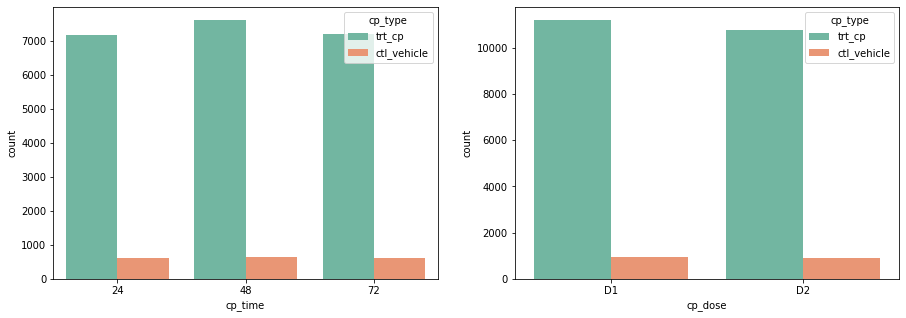

In [9]:
fig = plt.figure(figsize=(10,5))
plt.subplots_adjust(right=1.3)
plt.subplot(1, 2, 1)
sns.countplot(df_train['cp_time'],palette='Set2',hue = df_train['cp_type'])
plt.subplot(1, 2, 2)
sns.countplot(df_train['cp_dose'],palette='Set2',hue = df_train['cp_type'])
plt.show()

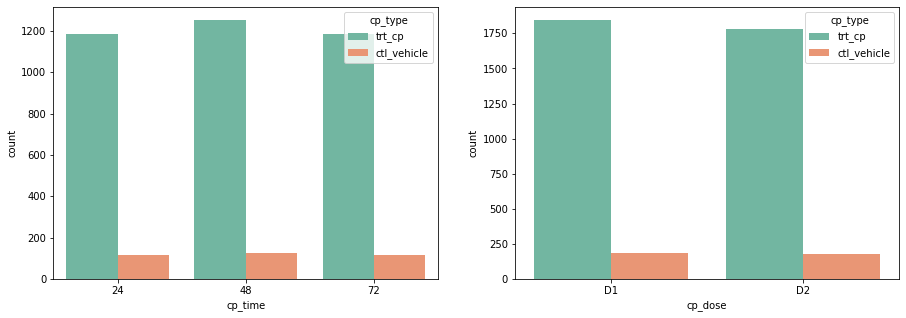

In [10]:
fig = plt.figure(figsize=(10,5))
plt.subplots_adjust(right=1.3)
plt.subplot(1, 2, 1)
sns.countplot(df_test['cp_time'],palette='Set2',hue = df_test['cp_type'])
plt.subplot(1, 2, 2)
sns.countplot(df_test['cp_dose'],palette='Set2',hue = df_test['cp_type'])
plt.show()

> cp_type 별로 범주형 특성 시각화 
>> 복용시간과 복용량은 고르게 분포하고 있으며 control의 데이터가 compound데이터보다 많이 적음

In [11]:
g_features = [cols for cols in df_train.columns if cols.startswith('g-')]
c_features = [cols for cols in df_train.columns if cols.startswith('c-')]

In [12]:
def plot_set_histograms(plot_list, title):
    fig = make_subplots(
        rows=4, 
        cols=3
    )
    
    traces = [
        go.Histogram(
            x=df_train[col], 
            nbinsx=100, 
            name=col
        ) for col in plot_list
    ]

    for i in range(len(traces)):
        fig.append_trace(
            traces[i], 
            (i // 3) + 1, 
            (i % 3) + 1
        )

    fig.update_layout(
        title_text=title,
        height=1000,
        width=1000
    )
    fig.show()

In [13]:
plot_list = [
    g_features[
        np.random.randint(0, len(g_features)-1)
    ] for i in range(50)
]

plot_list = list(set(plot_list))[:12]
plot_set_histograms(plot_list, 'Randomly selected gene expression features distributions')

Output hidden; open in https://colab.research.google.com to view.

In [14]:
plot_list = [
    c_features[
        np.random.randint(0, len(c_features)-1)
    ] for i in range(50)
]

plot_list = list(set(plot_list))[:12]
plot_set_histograms(plot_list, 'Randomly selected cell expression features distributions')

Output hidden; open in https://colab.research.google.com to view.

> gene expression 특성과 cell viability 특성을 random하게 그려준 결과

In [15]:
len(g_features), len(c_features)

(772, 100)

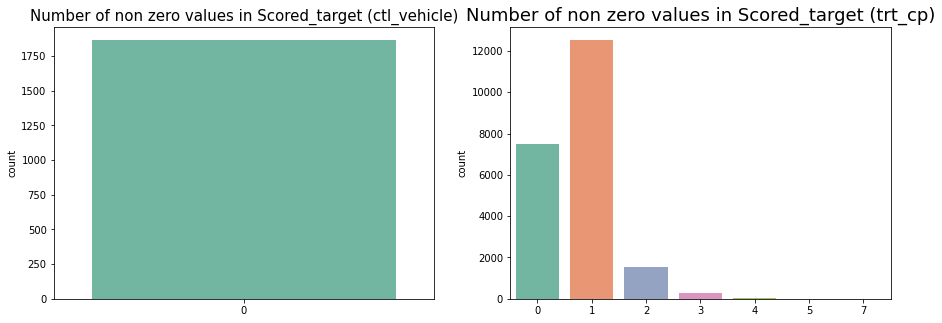

In [16]:
plt.figure(figsize=(15,5))

control_id = df_train.loc[df_train['cp_type'] == 'ctl_vehicle','sig_id']
plt.subplot(1,2,1)
plt.title('Number of non zero values in Scored_target (ctl_vehicle)', fontsize = 15)
sns.countplot(df_train_s.iloc[control_id.index,1:].sum(axis = 1), palette= 'Set2')

trt_cp_id = df_train.loc[df_train['cp_type'] == 'trt_cp','sig_id']
plt.subplot(1,2,2)
plt.title('Number of non zero values in Scored_target (trt_cp)', fontsize = 18)
sns.countplot(df_train_s.iloc[trt_cp_id.index,1:].sum(axis = 1),palette = 'Set2')

> cp_type별 scored target의 행별(drug)로 non-zero값을 counting한 결과
>> control일때 MOA가 없음!

In [17]:
df_train_s.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


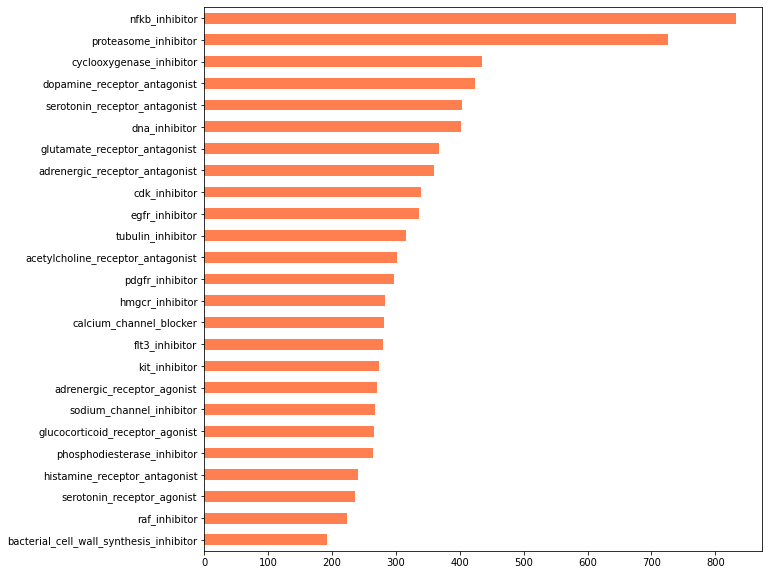

In [18]:
df_train_s_copy = df_train_s.copy()
df_train_s_copy.drop('sig_id',axis = 1 , inplace = True)
plt.figure(figsize=(10,10))
df_train_s_copy.sum().sort_values()[-25:].plot(kind='barh',color='coral')
plt.show()

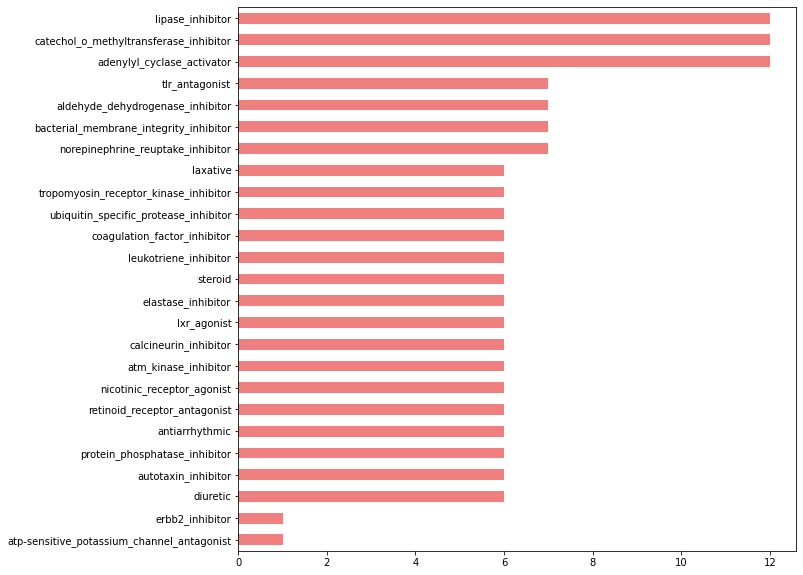

In [19]:
plt.figure(figsize=(10,10))
df_train_s_copy.sum().sort_values()[:25].plot(kind='barh',color='lightcoral')
plt.show()

> train_scored_target에서 가장 높은 빈도와 낮은 빈도의 target 시각화

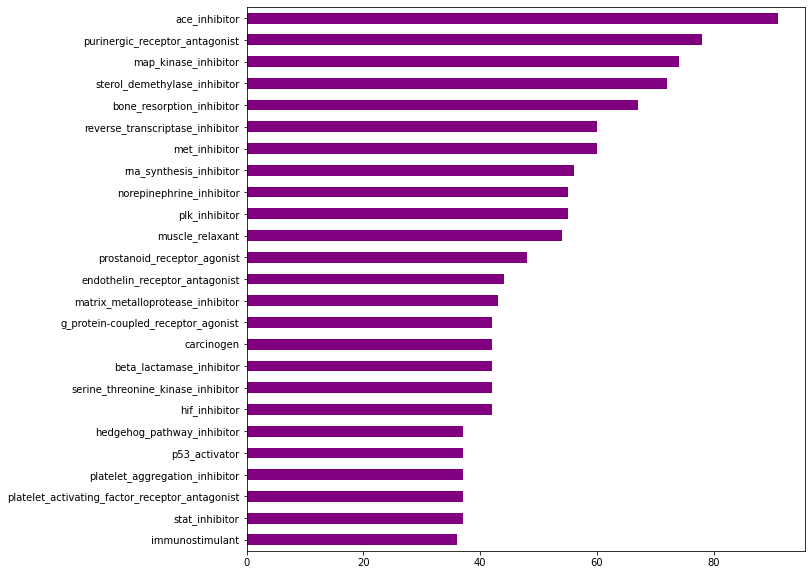

In [20]:
df_train_ns_copy = df_train_ns.copy()
df_train_ns_copy.drop('sig_id',axis = 1 , inplace = True)
plt.figure(figsize=(10,10))
df_train_ns_copy.sum().sort_values()[-25:].plot(kind='barh',color='purple')
plt.show()

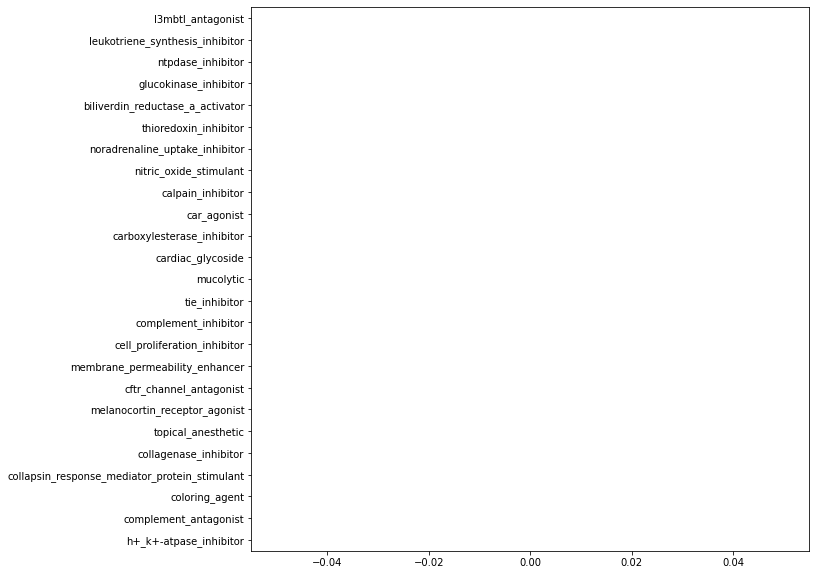

In [21]:
plt.figure(figsize=(10,10))
df_train_ns_copy.sum().sort_values()[:25].plot(kind='barh',color='purple')
plt.show()

> train_non_scored_target 에서 가장 높은 빈도와 낮은 빈도의 target 시각화

In [22]:
df_g_corr = df_train[g_features].corr()
g = df_g_corr.unstack()
g_c = g.sort_values(kind="quicksort", ascending=False)

In [23]:
g_c2= pd.DataFrame(g_c).reset_index()
g_c2= g_c2.rename(columns={0: 'correlation', 'level_0':'Gene 1', 'level_1': 'Gene 2'})
g_c2= g_c2[g_c2['correlation'] != 1]
g_c2

,Gene 1,Gene 2,correlation
772,g-50,g-37,0.907061
773,g-37,g-50,0.907061
774,g-50,g-672,0.845668
775,g-672,g-50,0.845668
776,g-489,g-37,0.842525
...,...,...,...
595979,g-744,g-228,-0.808788
595980,g-760,g-248,-0.809137
595981,g-248,g-760,-0.809137
595982,g-349,g-228,-0.820275


In [24]:
con1 = (g_c2['correlation']>= 0.8) | (g_c2['correlation'] <= -0.8)==True
g_high_corr = g_c2[con1][(g_c2[con1].index % 2) == 0 ]
g_high_corr

,Gene 1,Gene 2,correlation
772,g-50,g-37,0.907061
774,g-50,g-672,0.845668
776,g-489,g-37,0.842525
778,g-489,g-50,0.840404
780,g-460,g-349,0.836859
782,g-369,g-569,0.834865
784,g-123,g-744,0.833150
786,g-195,g-63,0.832779
788,g-672,g-121,0.830927
790,g-410,g-369,0.825646


> 연관성이 높은 gene_expression을 나타내는 데이터프레임 생성

In [25]:
df_c_corr = df_train[c_features].corr()
c = df_c_corr.unstack()
c_c = c.sort_values(kind="quicksort", ascending=False)

In [26]:
c_c2= pd.DataFrame(c_c).reset_index()
c_c2= c_c2.rename(columns={0: 'correlation', 'level_0':'cell 1', 'level_1': 'cell 2'})
c_c2= c_c2[c_c2['correlation'] != 1]

In [27]:
con2 = (c_c2['correlation']>= 0.9) | (c_c2['correlation'] <= -0.9)==True
c_high_corr = c_c2[con2][(c_c2[con2].index % 2) == 0 ]
c_high_corr

,cell 1,cell 2,correlation
100,c-42,c-52,0.924619
102,c-13,c-73,0.923344
104,c-26,c-13,0.921875
106,c-33,c-6,0.914730
108,c-55,c-11,0.914637
...,...,...,...
306,c-94,c-4,0.900309
308,c-62,c-6,0.900072
310,c-11,c-13,0.900071
312,c-96,c-6,0.900005


> 연관성이 높은 cell_viability를 나타내는 데이터프레임 생성

In [28]:
def plot_target_kind(col_list):
  inhibit = 0
  antago = 0
  ago = 0
  act = 0
  agent = 0
  for col in col_list : 
   if str(col).endswith('inhibitor') == True :
    inhibit +=1
   if str(col).endswith('antagonist') == True :
    antago +=1
   if str(col).endswith('agonist') == True :
    ago +=1
   if str(col).endswith('activator') == True :
    act +=1
   if str(col).endswith('agent') == True :
    agent +=1
  df = pd.DataFrame([[inhibit, antago, ago, act, agent]], columns = ['inhibitor','antagonist','agonist', 'activator', 'agent'])
  return df

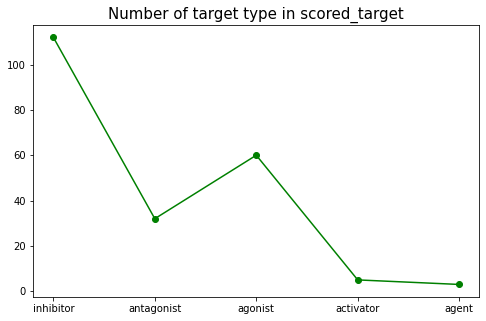

In [29]:
 plt.figure(figsize = (8,5))
 plt.title('Number of target type in scored_target', fontsize = 15)
 plt.plot(plot_target_kind(list(df_train_s.columns)).T,'go-')
 plt.show()

> target의 종류를 조사 총 207개중 대부분을 3개의 특성으로 묶을 수 있었음(inhibitor, antagonist, agonist)

In [30]:
plot_target_kind(list(df_train_s.columns))

,inhibitor,antagonist,agonist,activator,agent
0,112,32,60,5,3


# Preprocessing

#### 순서 
1. Variance threshold
2. Standardscaler
3. PCA 
> 올바른 순서?

#### 1. Variance threshold

In [31]:
train_test = pd.concat([df_train, df_test], ignore_index = True)
gene = [cols for cols in train_test.columns if cols.startswith('g-')]
cell = [cols for cols in train_test.columns if cols.startswith('c-')]

In [32]:
len(gene), len(cell)

(772, 100)

In [33]:
VT = VarianceThreshold(threshold = 0.7)
train_gene = VT.fit_transform(df_train[gene])
test_gene = VT.transform(df_test[gene])

In [34]:
train_gene.shape, test_gene.shape

((23814, 740), (3982, 740))

In [35]:
train_numeric = pd.concat([pd.DataFrame(train_gene), df_train[cell]], axis = 1)
test_numeric = pd.concat([pd.DataFrame(test_gene), df_test[cell]], axis = 1)

#### 2. StandardScaler

In [36]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_numeric)
test_scaled = scaler.transform(test_numeric)

In [37]:
train_scaled.shape, test_scaled.shape

((23814, 840), (3982, 840))

In [38]:
train_scaled = pd.DataFrame(train_scaled)
test_scaled = pd.DataFrame(test_scaled)

3. PCA

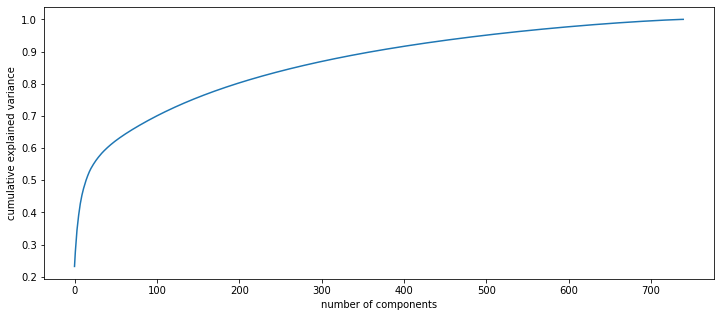

In [39]:
pca = PCA().fit(train_scaled.iloc[:,:740])
plt.figure(figsize = (12, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [108]:
pca_thres = np.cumsum(pca.explained_variance_ratio_)
np.where((0.69 < pca_thres) & (pca_thres < 0.71))

(array([ 93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107]),)

In [109]:
n_comp_genes = 100

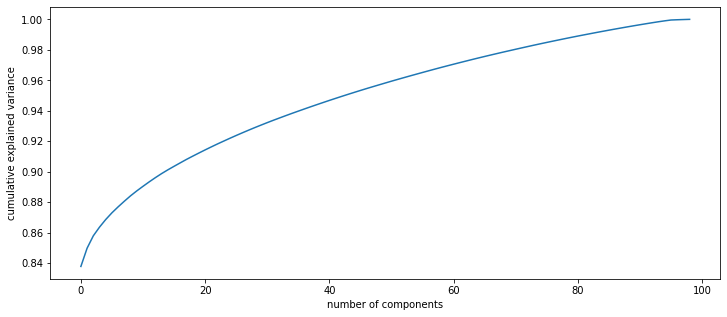

In [110]:
pca2 = PCA().fit(train_scaled.iloc[:,740+1:])
plt.figure(figsize = (12, 5))
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [111]:
pca2_thres = np.cumsum(pca2.explained_variance_ratio_)
np.where((0.84< pca2_thres) & (pca2_thres < 0.86))

(array([1, 2]),)

In [112]:
n_comp_cells = 1

In [113]:
pca_gene = PCA(n_components=n_comp_genes, random_state=2021)
train_gene_pca = pca_gene.fit_transform(train_scaled.iloc[:,:740])
test_gene_pca = pca_gene.transform(test_scaled.iloc[:,:740])

pca_cell = PCA(n_components=n_comp_cells, random_state=2021)
train_cell_pca = pca_cell.fit_transform(train_scaled.iloc[:,740+1:])
test_cell_pca = pca_cell.transform(test_scaled.iloc[:,740+1:])

In [114]:
train_gene_pca.shape, test_gene_pca.shape, train_cell_pca.shape, test_cell_pca.shape

((23814, 100), (3982, 100), (23814, 1), (3982, 1))

In [115]:
train_gene_pca.shape[1]

100

In [116]:
g_col1 = []
c_col1 = []
for i in range(train_gene_pca.shape[1]) :
  g_col1.append(str('gene-')+str(i+1) )
for j in range(train_cell_pca.shape[1]):
  c_col1.append(str('cell-')+str(j))

In [117]:
train_pca = pd.concat([pd.DataFrame(train_gene_pca,columns = g_col1), pd.DataFrame(train_cell_pca, columns = c_col1)],axis = 1)
test_pca = pd.concat([pd.DataFrame(test_gene_pca, columns = g_col1), pd.DataFrame(test_cell_pca, columns = c_col1)],axis = 1)

In [118]:
train_pca.shape, test_pca.shape

((23814, 101), (3982, 101))

#### + One-hot

In [119]:
train_features = pd.DataFrame(df_train[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),
                              columns=['sig_id','cp_type','cp_time','cp_dose'])

train_features = pd.concat([train_features, pd.DataFrame(train_pca)], axis=1)


test_features = pd.DataFrame(df_test[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),
                             columns=['sig_id','cp_type','cp_time','cp_dose'])

test_features = pd.concat([test_features, pd.DataFrame(test_pca)], axis=1)


In [120]:
test_features

,sig_id,cp_type,cp_time,cp_dose,gene-1,gene-2,gene-3,gene-4,gene-5,gene-6,gene-7,gene-8,gene-9,gene-10,gene-11,gene-12,gene-13,gene-14,gene-15,gene-16,gene-17,gene-18,gene-19,gene-20,gene-21,gene-22,gene-23,gene-24,gene-25,gene-26,gene-27,gene-28,gene-29,gene-30,gene-31,gene-32,gene-33,gene-34,gene-35,gene-36,...,gene-62,gene-63,gene-64,gene-65,gene-66,gene-67,gene-68,gene-69,gene-70,gene-71,gene-72,gene-73,gene-74,gene-75,gene-76,gene-77,gene-78,gene-79,gene-80,gene-81,gene-82,gene-83,gene-84,gene-85,gene-86,gene-87,gene-88,gene-89,gene-90,gene-91,gene-92,gene-93,gene-94,gene-95,gene-96,gene-97,gene-98,gene-99,gene-100,cell-0
0,id_0004d9e33,trt_cp,24,D1,-3.206874,2.009899,0.508731,-1.771031,1.273474,-1.506191,0.531629,-0.891150,2.101884,1.051802,-1.089330,-1.351866,0.002333,0.973462,-1.245979,-1.387850,-0.383259,0.340173,-0.326305,-2.847963,-2.068089,0.945320,-1.105212,1.109949,-1.519460,-2.683334,-0.184812,0.177901,-0.280059,0.047421,1.379839,0.929967,0.559750,0.355339,0.177239,1.434768,...,-0.301002,-0.329914,0.844996,-0.887799,-0.388960,-0.554535,-1.006584,-0.109862,-0.663692,1.267418,-1.054691,-0.844597,-1.084236,1.466497,0.840528,0.569914,1.727722,-0.346045,0.269500,0.579569,-0.409479,0.366334,-0.665393,-0.559046,0.272350,-0.799593,0.396841,-1.889598,0.342863,-0.662039,-0.504638,0.871431,-1.446191,1.159068,-0.639802,-0.210300,1.136384,-1.264235,0.472938,-1.606747
1,id_001897cda,trt_cp,72,D1,-3.028763,-3.315981,-1.691901,5.816726,-1.649915,-7.100288,-4.194351,3.355614,0.495954,1.881278,2.639055,0.944467,-0.070335,-0.326323,-2.854756,-1.282266,-1.534595,-0.199957,0.036770,0.968016,0.892226,0.838050,-1.529277,-1.191333,0.396967,-2.727556,-1.396847,-0.468577,0.212851,-1.252728,0.427559,-0.745756,-1.565264,-1.910288,0.971546,-0.392599,...,1.564039,0.290799,-2.116003,-0.922338,0.739146,-0.350734,1.244707,0.420459,0.876875,-0.522294,-0.141849,-0.294294,0.173609,0.311359,0.144204,-0.883518,0.974076,1.359924,-0.411406,-0.567791,1.146193,-1.773633,-0.082713,-0.720536,-0.350674,-1.004076,-0.126975,-0.427046,-1.005990,0.007969,-0.518747,0.417506,-0.206137,-0.129403,-1.029789,-0.313120,-0.321428,-0.426572,0.329432,0.717098
2,id_002429b5b,ctl_vehicle,24,D1,-6.133715,0.560772,-1.565528,5.312836,3.968031,6.018686,-1.463333,-1.587426,-2.507119,1.536521,2.338266,-0.822475,0.625201,-0.211406,1.118850,-0.132147,2.730039,0.015293,0.482962,-0.269343,1.640985,-1.796708,0.294548,2.529838,-0.439226,0.356354,-1.374544,-0.608206,-0.448462,0.992298,-0.853989,-0.340099,-0.539337,-0.128836,-0.412172,-1.881499,...,-1.133239,0.849969,-1.337850,-1.170434,0.301813,0.238800,-0.585184,-0.630876,-0.229636,0.906672,-0.446521,0.150437,-0.652495,1.429645,-0.311374,-0.935185,1.493585,0.752160,-0.641146,-0.744920,1.308950,1.615153,-0.951819,-0.219793,0.077851,0.247139,-0.156220,-0.350085,0.693975,0.373769,0.159634,0.988672,0.888859,-0.720511,0.298932,-0.299831,-0.312375,-0.081827,-1.203601,-3.227758
3,id_00276f245,trt_cp,24,D2,-2.565383,-0.282489,-3.986782,5.352637,0.177433,1.277422,-0.452643,-0.337122,-3.457003,-1.646449,2.254753,-0.794171,-1.575443,-1.152566,1.343879,-1.930471,0.047317,0.099069,-1.698714,-0.311965,-1.058038,-0.051898,0.794086,-2.513765,-0.595012,1.734530,0.312594,0.971405,0.926621,-2.623813,-1.313209,-1.282104,0.099564,0.123924,0.167381,0.280562,...,-0.004942,-0.442411,-0.666456,-2.651484,1.820901,0.423940,0.974349,2.260991,0.907718,-0.089586,-0.149967,-0.187327,1.018668,0.267229,0.014924,1.929000,1.079158,-1.325870,-1.797522,-1.114978,0.209544,-1.314617,-1.285324,1.133914,-0.572861,-0.373883,-0.060315,0.465921,0.460951,-0.448868,-0.749484,-0.756724,-1.829345,-0.348566,-0.058594,-0.702496,0.262855,-0.554907,-1.447738,-1.306567
4,id_0027f1083,trt_cp,48,D1,-6.508293,1.732672,3.595607,-0.056303,1.227090,4.558121,-0.037756,-1.581867,-1.372345,1.759155,1.022681,-0.173959,1.402619,0.963383,0.009314,1.270051,0.018193,-1.359226,0.270923,0.788774,-0.007052,-1.419088,-1.030764,0.192299,1.504581,-0.195400,-0.027161,-0.526817,-0.207570,0.254594,0.168923,-

In [121]:
train = pd.get_dummies(train_features, columns=['cp_time','cp_dose'])
test = pd.get_dummies(test_features, columns=['cp_time','cp_dose'])

time과 dose에 대해서만 더미 변수생성

In [122]:
train = train.merge(df_train_s, on = 'sig_id')
train_final = train[train['cp_type']!= 'ctl_vehicle'].reset_index(drop =True)
test_final = test[test['cp_type']!='ctl_vehicle'].reset_index(drop=True)

In [123]:
test_final

,sig_id,cp_type,gene-1,gene-2,gene-3,gene-4,gene-5,gene-6,gene-7,gene-8,gene-9,gene-10,gene-11,gene-12,gene-13,gene-14,gene-15,gene-16,gene-17,gene-18,gene-19,gene-20,gene-21,gene-22,gene-23,gene-24,gene-25,gene-26,gene-27,gene-28,gene-29,gene-30,gene-31,gene-32,gene-33,gene-34,gene-35,gene-36,gene-37,gene-38,...,gene-67,gene-68,gene-69,gene-70,gene-71,gene-72,gene-73,gene-74,gene-75,gene-76,gene-77,gene-78,gene-79,gene-80,gene-81,gene-82,gene-83,gene-84,gene-85,gene-86,gene-87,gene-88,gene-89,gene-90,gene-91,gene-92,gene-93,gene-94,gene-95,gene-96,gene-97,gene-98,gene-99,gene-100,cell-0,cp_time_24,cp_time_48,cp_time_72,cp_dose_D1,cp_dose_D2
0,id_0004d9e33,trt_cp,-3.206874,2.009899,0.508731,-1.771031,1.273474,-1.506191,0.531629,-0.891150,2.101884,1.051802,-1.089330,-1.351866,0.002333,0.973462,-1.245979,-1.387850,-0.383259,0.340173,-0.326305,-2.847963,-2.068089,0.945320,-1.105212,1.109949,-1.519460,-2.683334,-0.184812,0.177901,-0.280059,0.047421,1.379839,0.929967,0.559750,0.355339,0.177239,1.434768,0.484682,0.954133,...,-0.554535,-1.006584,-0.109862,-0.663692,1.267418,-1.054691,-0.844597,-1.084236,1.466497,0.840528,0.569914,1.727722,-0.346045,0.269500,0.579569,-0.409479,0.366334,-0.665393,-0.559046,0.272350,-0.799593,0.396841,-1.889598,0.342863,-0.662039,-0.504638,0.871431,-1.446191,1.159068,-0.639802,-0.210300,1.136384,-1.264235,0.472938,-1.606747,1,0,0,1,0
1,id_001897cda,trt_cp,-3.028763,-3.315981,-1.691901,5.816726,-1.649915,-7.100288,-4.194351,3.355614,0.495954,1.881278,2.639055,0.944467,-0.070335,-0.326323,-2.854756,-1.282266,-1.534595,-0.199957,0.036770,0.968016,0.892226,0.838050,-1.529277,-1.191333,0.396967,-2.727556,-1.396847,-0.468577,0.212851,-1.252728,0.427559,-0.745756,-1.565264,-1.910288,0.971546,-0.392599,0.286560,2.389344,...,-0.350734,1.244707,0.420459,0.876875,-0.522294,-0.141849,-0.294294,0.173609,0.311359,0.144204,-0.883518,0.974076,1.359924,-0.411406,-0.567791,1.146193,-1.773633,-0.082713,-0.720536,-0.350674,-1.004076,-0.126975,-0.427046,-1.005990,0.007969,-0.518747,0.417506,-0.206137,-0.129403,-1.029789,-0.313120,-0.321428,-0.426572,0.329432,0.717098,0,0,1,1,0
2,id_00276f245,trt_cp,-2.565383,-0.282489,-3.986782,5.352637,0.177433,1.277422,-0.452643,-0.337122,-3.457003,-1.646449,2.254753,-0.794171,-1.575443,-1.152566,1.343879,-1.930471,0.047317,0.099069,-1.698714,-0.311965,-1.058038,-0.051898,0.794086,-2.513765,-0.595012,1.734530,0.312594,0.971405,0.926621,-2.623813,-1.313209,-1.282104,0.099564,0.123924,0.167381,0.280562,0.693834,0.276469,...,0.423940,0.974349,2.260991,0.907718,-0.089586,-0.149967,-0.187327,1.018668,0.267229,0.014924,1.929000,1.079158,-1.325870,-1.797522,-1.114978,0.209544,-1.314617,-1.285324,1.133914,-0.572861,-0.373883,-0.060315,0.465921,0.460951,-0.448868,-0.749484,-0.756724,-1.829345,-0.348566,-0.058594,-0.702496,0.262855,-0.554907,-1.447738,-1.306567,1,0,0,0,1
3,id_0027f1083,trt_cp,-6.508293,1.732672,3.595607,-0.056303,1.227090,4.558121,-0.037756,-1.581867,-1.372345,1.759155,1.022681,-0.173959,1.402619,0.963383,0.009314,1.270051,0.018193,-1.359226,0.270923,0.788774,-0.007052,-1.419088,-1.030764,0.192299,1.504581,-0.195400,-0.027161,-0.526817,-0.207570,0.254594,0.168923,-0.175525,0.153345,-0.267693,0.403991,0.054775,0.334861,0.202383,...,0.840423,0.432298,0.989507,1.028162,-1.152531,0.599187,-0.807745,0.548071,-0.209404,1.032712,0.494643,0.874872,-1.312353,-0.579225,0.347085,-0.628499,1.322214,0.684315,-0.524973,-0.921471,0.270130,0.031085,0.301457,-1.031644,-0.529959,0.650078,-0.549541,0.636325,-0.685640,-1.445215,0.097190,1.027487,0.040825,0.375514,-5.051028,0,1,0,1,0
4,id_006fc47b8,trt_cp,-4.092829,0.585696,5.633560,8.963029,-1.860620,-6.376383,-0.180998,0.150569,-2.233351,0.700025,2.400435,-2.438783,-1.708095,-0.923615,0.326820,-1.910952,1.279778,-0.158509,-0.284135,-0.716054,-0.019899,0.806835,1.279214,2.469120,1.366314,1.081074,-0.752825,-0.231628,-0.537078,-0.002986,-0.329609,-0.620590,-0.810416,0.196362,1.335191,0.077000,1.306311,-2.314046,...,-1.025211,-0.147937,1.560501,0.589081

모든 타겟이 0이었던 vehicle 제외

In [124]:
train_final.shape, test_final.shape

((21948, 314), (3624, 108))

In [125]:
train_final.iloc[:,66:]

,gene-65,gene-66,gene-67,gene-68,gene-69,gene-70,gene-71,gene-72,gene-73,gene-74,gene-75,gene-76,gene-77,gene-78,gene-79,gene-80,gene-81,gene-82,gene-83,gene-84,gene-85,gene-86,gene-87,gene-88,gene-89,gene-90,gene-91,gene-92,gene-93,gene-94,gene-95,gene-96,gene-97,gene-98,gene-99,gene-100,cell-0,cp_time_24,cp_time_48,cp_time_72,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,-0.013245,-0.734826,1.420994,0.241048,-0.798680,0.280002,-0.695420,0.103576,-0.228706,0.373680,-1.337294,0.254659,0.326136,-0.236065,0.516398,-0.621806,0.287867,0.358411,-0.212978,-1.014005,0.159309,0.362476,0.066659,0.194353,0.420892,0.138202,-0.543819,1.092235,-0.144658,0.140039,-0.169759,-0.692044,0.733774,-1.911082,-0.721275,0.237905,-3.891999,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.930137,0.504639,0.464498,0.040010,0.877060,-1.202514,-0.300002,-0.347840,-0.809299,-0.030408,0.671879,0.206267,-0.823671,0.574089,0.406191,-1.033265,-0.954525,1.282445,-0.312904,1.711372,-1.978840,0.971339,1.132646,-0.624790,0.670872,0.581959,0.328547,-0.167107,-0.760264,0.262175,0.454867,-0.079300,-1.053899,0.454371,-1.437248,-0.299891,-3.986911,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.060704,0.563417,1.131410,2.330931,-0.554061,0.131439,-1.121956,-1.167960,-1.484019,1.378833,-0.140766,-2.952493,1.222866,0.617657,1.135848,-0.799222,-1.139718,-1.831484,1.581004,0.769947,-1.963273,-1.794603,0.060698,-1.012738,-0.470666,-1.433533,0.242426,-0.136239,-0.919610,0.521894,0.955177,-0.520955,-1.868314,-0.117674,0.169594,-1.193566,-1.232296,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-1.102596,0.669579,0.104686,-1.748382,0.260638,-1.492482,-1.103649,0.149523,0.187399,-0.707198,0.077795,-0.638618,-0.488668,0.403932,-0.339084,-2.504048,1.217617,-0.625270,-0.515966,-1.694048,-1.104258,1.973653,0.361705,2.213780,-0.314455,1.179292,0.671919,-0.942218,-0.243765,-0.603657,-1.880862,-1.150878,-0.184919,1.424703,-0.191569,0.016507,6.922960,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.733684,-1.713308,1.954513,-2.314024,0.243225,-0.770716,-0.626089,-0.398578,0.036737,-1.425919,2.281385,0.363180,-0.301065,-1.401269,0.625787,-0.646097,0.225987,0.204411,-0.433088,-0.443814,-1.821317,-1.145265,-1.029009,0.566959,0.347001,-0.553856,1.142855,0.155756,0.379194,0.211356,2.680187,1.318665,1.072851,-0.729527,1.772085,0.686714,-3.436483,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21943,-0.401230,0.230977,-0.233181,-1.714903,0.174677,-0.092110,-0.336594,-0.286246,-2.171726,0.584757,-0.698985,0.437984,-0.364459,0.781636,0.544655,0.164291,1.526642,0.3

# Modeling

In [92]:
!pip install iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [126]:
import random
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [127]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [128]:
folds = train_final.copy()
split = MultilabelStratifiedKFold(n_splits=5, random_state=2021)
for f,(train_index, val_index) in enumerate(split.split(train_final, train_final.iloc[:,67:])):
  folds.loc[val_index, 'kfold'] = int(f)

folds['kfold'] = folds['kfold'].astype(int)

In [129]:
folds['kfold'].value_counts()

4    4390
2    4390
0    4390
3    4389
1    4389
Name: kfold, dtype: int64

In [130]:
target_cols = df_train_s.drop('sig_id', axis=1).columns.values.tolist()
feature_cols = [c for c in folds.columns if c not in target_cols]
feature_cols = [c for c in feature_cols if c not in ['cp_type', 'kfold', 'sig_id']]
len(target_cols), len(feature_cols)

(206, 106)

In [131]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct

In [132]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
#         print(inputs.shape)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    
    return final_loss


def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds

In [133]:
class Model(nn.Module):
    def __init__(self, num_features, num_targets, hidden_size):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(0.3)
        self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(0.3)
        self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size, num_targets))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

In [134]:
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 40
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
NFOLDS = 5
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False

num_features=len(feature_cols)
num_targets=len(target_cols)
hidden_size=1024

In [135]:
def run_training(fold, seed):
    
    seed_everything(seed)
    
    trn_idx = folds[folds['kfold'] != fold].index
    val_idx = folds[folds['kfold'] == fold].index
    
    train_df = folds[folds['kfold'] != fold].reset_index(drop=True)
    valid_df = folds[folds['kfold'] == fold].reset_index(drop=True)

    x_train, y_train  = train_df[feature_cols].values, train_df[target_cols].values
    x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols].values
    
    train_dataset = MoADataset(x_train, y_train)
    valid_dataset = MoADataset(x_valid, y_valid)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
    )
    
    model.to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))
    
    loss_fn = nn.BCEWithLogitsLoss()
    
    early_stopping_steps = EARLY_STOPPING_STEPS
    early_step = 0
    
    oof = np.zeros((len(folds), len(target_cols)))
    best_loss = np.inf
    
    for epoch in range(EPOCHS):
        
        train_loss = train_fn(model, optimizer,scheduler, loss_fn, trainloader, DEVICE)
        print(f"FOLD: {fold},EPOCH: {epoch}, train_loss: {train_loss}")
        valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
        print(f"FOLD: {fold},EPOCH: {epoch}, valid_loss: {valid_loss}")
        
        if valid_loss < best_loss:
            
            best_loss = valid_loss
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f"FOLD{fold}_.pth")
        
        elif(EARLY_STOP == True):
            
            early_step += 1
            if (early_step >= early_stopping_steps):
                break
            
    #--------------------- PREDICTION---------------------
    x_test = test_final[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
    )
    
    model.load_state_dict(torch.load(f"FOLD{fold}_.pth"))
    model.to(DEVICE)
    
    predictions = np.zeros((x_test.shape[0],len(target_cols)))
    predictions = inference_fn(model, testloader, DEVICE)
    
    return oof, predictions

In [136]:
def run_k_fold(NFOLDS, seed):
    oof = np.zeros((len(folds), len(target_cols)))
    predictions = np.zeros((len(test_final), len(target_cols)))
    
    for fold in range(NFOLDS):
        oof_, pred_ = run_training(fold, seed)
        print('-'*50)
        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions

In [137]:
oof, predictions = run_k_fold(NFOLDS,42)

FOLD: 0,EPOCH: 0, train_loss: 0.6534209526751352
FOLD: 0,EPOCH: 0, valid_loss: 0.21600190911974226
FOLD: 0,EPOCH: 1, train_loss: 0.0512635671277193
FOLD: 0,EPOCH: 1, valid_loss: 0.020121926441788673
FOLD: 0,EPOCH: 2, train_loss: 0.01984465868630703
FOLD: 0,EPOCH: 2, valid_loss: 0.018815885058471135
FOLD: 0,EPOCH: 3, train_loss: 0.019206215215819902
FOLD: 0,EPOCH: 3, valid_loss: 0.018549835522259986
FOLD: 0,EPOCH: 4, train_loss: 0.01870609756451154
FOLD: 0,EPOCH: 4, valid_loss: 0.018046987269605907
FOLD: 0,EPOCH: 5, train_loss: 0.018090371022243864
FOLD: 0,EPOCH: 5, valid_loss: 0.01792851872742176
FOLD: 0,EPOCH: 6, train_loss: 0.01788440463470592
FOLD: 0,EPOCH: 6, valid_loss: 0.017794450159583773
FOLD: 0,EPOCH: 7, train_loss: 0.017852148594523685
FOLD: 0,EPOCH: 7, valid_loss: 0.017811323489461628
FOLD: 0,EPOCH: 8, train_loss: 0.017767047556792048
FOLD: 0,EPOCH: 8, valid_loss: 0.017784638702869414
FOLD: 0,EPOCH: 9, train_loss: 0.01781348073585094
FOLD: 0,EPOCH: 9, valid_loss: 0.017732611

In [138]:
from sklearn.metrics import log_loss, roc_auc_score

In [139]:
folds[target_cols] = oof
test_final[target_cols] = predictions

In [140]:
y_true = df_train_s[target_cols].values
valid_results = df_train_s.drop(columns=target_cols).merge(folds[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
y_pred = valid_results[target_cols].values

score = []
auc = []
for i in range(len(target_cols)):
    score_ = log_loss(y_true[:, i], y_pred[:, i])
    auc_ = roc_auc_score(y_true[:, i], y_pred[:, i])
    score.append(score_ )
    auc.append(auc_)
    
print("CV log_loss: ", np.mean(score))
print("CV AUC: ", np.mean(auc))

CV log_loss:  0.015648593004377646
CV AUC:  0.7784173796824427
